## 통합 데이터셋

In [130]:
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:,.0f}')
pd.set_option('display.max_columns', None)

# 데이터 로드
data_path = '../../data/training/preprocessing/final_traveler.csv'
df = pd.read_csv(data_path)
print('shape:', df.shape)

shape: (2560, 80)


In [131]:
# 필요없는 컬럼 삭제
cols = ['TRAVELER_ID', 'TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA', 'activity_payment_count'
        , 'activity_store_count', 'activity_history_rows', 'activity_type_unique', 'lodging_payment_count', 'lodging_store_count'
        , 'RESIDENCE_SGG_CD', 'EDU_NM', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4'
        , 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8', 'TRAVEL_STATUS_YMD'
        , 'TRAVEL_PURPOSE_22', 'TRAVEL_PURPOSE_1', 'TRAVEL_PURPOSE_6', 'TRAVEL_PURPOSE_4', 'TRAVEL_PURPOSE_2', 'TRAVEL_PURPOSE_26'
        , 'TRAVEL_PURPOSE_21', 'TRAVEL_PURPOSE_24', 'TRAVEL_PURPOSE_3', 'TRAVEL_PURPOSE_5', 'TRAVEL_PURPOSE_OTHER'
        , 'TRAVEL_PURPOSE_COUNT', 'TRAVEL_MISSION_CHECK_22', 'TRAVEL_MISSION_CHECK_1', 'TRAVEL_MISSION_CHECK_6'
        , 'TRAVEL_MISSION_CHECK_2', 'TRAVEL_MISSION_CHECK_21', 'TRAVEL_MISSION_CHECK_4', 'TRAVEL_MISSION_CHECK_24'
        , 'TRAVEL_MISSION_CHECK_3', 'TRAVEL_MISSION_CHECK_26', 'TRAVEL_MISSION_CHECK_5', 'TRAVEL_MISSION_CHECK_OTHER', 'TRAVEL_MISSION_CHECK_COUNT']

df = df.drop(columns = cols, axis = 1)

In [132]:
# # travel_mission, activity_type_code 추가
# 이름 통일(대문자)
# eda용으로 한글명 테이블도 혹은 변수이름매핑함수
# ---

# 1단계 각자 테이블에서 필요하다고 생각한 컬럼들 정제해서 만들었음(eda진행해서 만들 컬럼을 도출했음 >> 변수생성)
# 2단계 travel_id 기준 병합 
# 3단계 결측치와 이상치를 확인 -> 결측치는 아래 내용으로 전처리하기로 결정 / 이상치 
# - MVMN_NM 정보없음 대체
# - 코드 컬럼들은 전체 대비 비율이 너무 적은지 시각화해서 차이 보고 심하면 의미 비슷한거와 범위 합치기(단, 그 비율 적은게 강한 정보를 담고 있으면 냅두는게나음)
# 4단계 데이터 가공(TRAVEL ID 기준 컬럼계산해서 총소비금액 등등)
# - visit_dgstfn_avg / visit_revisit_avg / visit_rcmdin_avg 여행망함여부(타겟변수)생성
# 5단계 여기까진 된 데이터로 eda + 근데 타겟변수랑 시각화(seaborn만)는 봄

# 6단계 학습을 위한 데이터 준비
# 피처생성단계
# TRAVEL_START_YMD 월별컬럼, 계절컬럼
# travel_mission과 travel_mission_check 비교해서 실제로 하려고햇던 여행활동을 했는지 컬럼 생성 (y/n)
# lodging_payment_sum 숙박비합계컬럼 생성
# visit_rate 재방문여부에서 비율로 변경해서 컬럼생성

# 데이터 저장
# df.to_csv('../../data/training/preprocessing/final_prep_data.csv', encoding='utf-8-sig')

### 1단계: 기본 컬럼 정리와 날짜 파생
- final_traveler.csv에서 핵심 지표만 골라내고 문자열/날짜 형식을 통일합니다.
- 여행 시작과 종료 정보를 활용해 기간·지연 일수를 계산해 둡니다.

In [133]:
import numpy as np
from IPython.display import display

base_columns = [
    'TRAVEL_ID', 'TRAVELER_ID', 'TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA',
    'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_STATUS_YMD', 'MVMN_NM',
    'TRAVEL_MISSION_CHECK', 'activity_payment_sum', 'activity_payment_count',
    'activity_store_count', 'lodging_payment_sum', 'lodging_payment_count',
    'lodging_store_count', 'visit_dgstfn_avg', 'visit_revisit_avg',
    'visit_rcmdtn_avg', 'visit_trip_days', 'visit_move_cnt', 'visit_rate',
    'GENDER', 'AGE_GRP', 'INCOME', 'HOUSE_INCOME', 'TRAVEL_TERM',
    'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM', 'TRAVEL_STATUS_ACCOMPANY'
]
selected_cols = [col for col in base_columns if col in df.columns]
eda_df = df[selected_cols].copy()

string_cols = [
    col for col in ['TRAVEL_NM', 'TRAVEL_PURPOSE', 'TRAVEL_PERSONA', 'MVMN_NM', 'TRAVEL_STATUS_ACCOMPANY']
    if col in eda_df.columns
]
for col in string_cols:
    eda_df[col] = eda_df[col].astype('string').str.strip().str.upper()
if 'MVMN_NM' in eda_df.columns:
    eda_df['MVMN_NM'] = eda_df['MVMN_NM'].str.replace(r'\s+', ' ', regex=True)

for col in [c for c in ['TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_STATUS_YMD'] if c in eda_df.columns]:
    eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
if {'TRAVEL_START_YMD', 'TRAVEL_END_YMD'} <= set(eda_df.columns):
    eda_df['TRAVEL_DURATION_DAYS'] = (eda_df['TRAVEL_END_YMD'] - eda_df['TRAVEL_START_YMD']).dt.days
if {'TRAVEL_START_YMD', 'TRAVEL_STATUS_YMD'} <= set(eda_df.columns):
    eda_df['TRAVEL_STATUS_LAG_DAYS'] = (eda_df['TRAVEL_STATUS_YMD'] - eda_df['TRAVEL_START_YMD']).dt.days
if 'TRAVEL_START_YMD' in eda_df.columns:
    eda_df['TRAVEL_START_YEAR'] = eda_df['TRAVEL_START_YMD'].dt.year
    eda_df['TRAVEL_START_MONTH'] = eda_df['TRAVEL_START_YMD'].dt.month

### 2단계: 여행 미션 코드 파생
- travel.csv에서 여행별 미션 선택 횟수와 상위 미션 코드를 파생시킵니다.
- 빈 여행도 대응해 기본값을 0으로 채웁니다.

In [134]:
travel_raw = pd.read_csv('../../data/training/preprocessing/travel.csv', encoding='utf-8-sig')
mission_long = (
    travel_raw[['TRAVEL_ID', 'TRAVEL_MISSION_CHECK']]
    .assign(TRAVEL_MISSION_CHECK=lambda d: d['TRAVEL_MISSION_CHECK'].fillna(''))
    .assign(mission_list=lambda d: d['TRAVEL_MISSION_CHECK'].str.split(';'))
    .explode('mission_list')
)
mission_long = mission_long[mission_long['mission_list'].notna() & (mission_long['mission_list'] != '')]
mission_long['mission_list'] = mission_long['mission_list'].str.strip()

if mission_long.empty:
    mission_features = (
        eda_df[['TRAVEL_ID']]
        .drop_duplicates()
        .assign(MISSION_CODE_COUNT=0)
    )
else:
    mission_counts = (
        mission_long.groupby('TRAVEL_ID').size().rename('MISSION_CODE_COUNT').reset_index()
    )
    mission_top_codes = mission_long['mission_list'].value_counts().head(5).index.tolist()
    mission_pivot = (
        pd.crosstab(mission_long['TRAVEL_ID'], mission_long['mission_list'])
        .reindex(columns=mission_top_codes, fill_value=0)
        .add_prefix('MISSION_CD_')
        .reset_index()
    )
    mission_features = mission_counts.merge(mission_pivot, on='TRAVEL_ID', how='left').fillna(0)

### 3단계: 활동 내역 지표 생성
- activity_history.csv에서 활동 건수, 고유 유형 수, 상위 활동 유형 빈도를 계산합니다.
- 활동 데이터가 비어 있는 경우에는 0으로 표기합니다.

In [135]:
activity_hist = pd.read_csv('../../data/training/preprocessing/activity_history.csv', encoding='utf-8-sig')
activity_hist = activity_hist.dropna(subset=['TRAVEL_ID'])
activity_hist['ACTIVITY_TYPE_CD'] = (
    activity_hist['ACTIVITY_TYPE_CD']
    .astype('string')
    .str.strip()
    .str.upper()
)
activity_hist['ACTIVITY_TYPE_CD'] = activity_hist['ACTIVITY_TYPE_CD'].fillna('UNKNOWN')

if activity_hist.empty:
    activity_features = (
        eda_df[['TRAVEL_ID']]
        .drop_duplicates()
        .assign(activity_history_rows=0, activity_type_unique=0)
    )
else:
    activity_summary = (
        activity_hist.groupby('TRAVEL_ID')
        .agg(activity_history_rows=('ACTIVITY_TYPE_CD', 'size'), activity_type_unique=('ACTIVITY_TYPE_CD', 'nunique'))
        .reset_index()
    )
    activity_top_codes = activity_hist['ACTIVITY_TYPE_CD'].value_counts().head(5).index.tolist()
    activity_pivot = (
        pd.crosstab(activity_hist['TRAVEL_ID'], activity_hist['ACTIVITY_TYPE_CD'])
        .reindex(columns=activity_top_codes, fill_value=0)
        .add_prefix('ACTIVITY_CD_')
        .reset_index()
    )
    activity_features = activity_summary.merge(activity_pivot, on='TRAVEL_ID', how='left').fillna(0)

### 4단계: 파생 변수 결합 및 데이터 정렬
- 전 단계에서 만든 미션·활동 특성을 합치고 결측값을 정리합니다.
- 여행 ID 기준으로 정렬해 모델링 입력을 정돈합니다.

In [136]:
prepared_df = (
    eda_df.merge(mission_features, on='TRAVEL_ID', how='left')
          .merge(activity_features, on='TRAVEL_ID', how='left')
)
mission_cols = [col for col in prepared_df.columns if col.startswith('MISSION_CD_')]
activity_cols = [col for col in prepared_df.columns if col.startswith('ACTIVITY_CD_')]
if mission_cols:
    prepared_df[mission_cols] = prepared_df[mission_cols].fillna(0).astype(int)
if activity_cols:
    prepared_df[activity_cols] = prepared_df[activity_cols].fillna(0).astype(int)
if 'MISSION_CODE_COUNT' in prepared_df.columns:
    prepared_df['MISSION_CODE_COUNT'] = prepared_df['MISSION_CODE_COUNT'].fillna(0).astype(int)
prepared_df = prepared_df.sort_values('TRAVEL_ID').reset_index(drop=True)

### 5단계: 요약 통계와 이상치 검토
- 수치형 컬럼 통계, 분위 기반 이상치 개수를 확인해 데이터 품질을 빠르게 파악합니다.

In [137]:
numeric_cols = prepared_df.select_dtypes(include=[np.number]).columns
summary_stats = prepared_df[numeric_cols].describe().T
quantiles = prepared_df[numeric_cols].quantile([0.01, 0.99]).T
outlier_flags = (
    (prepared_df[numeric_cols] < quantiles[0.01]) | (prepared_df[numeric_cols] > quantiles[0.99])
)
outlier_counts = outlier_flags.sum().sort_values(ascending=False)
outlier_overview = outlier_counts[outlier_counts > 0].to_frame('outlier_count')

display(prepared_df.head())
display(summary_stats.head(10))
display(outlier_overview.head(10))

prepared_df.to_csv('../../data/training/preprocessing/travel_insights.csv', index=False, encoding='utf-8-sig')

,TRAVEL_ID,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_MISSION_CHECK,activity_payment_sum,lodging_payment_sum,visit_dgstfn_avg,visit_revisit_avg,visit_rcmdtn_avg,visit_trip_days,visit_move_cnt,visit_rate,GENDER,AGE_GRP,INCOME,HOUSE_INCOME,TRAVEL_COMPANIONS_NUM,TRAVEL_STATUS_ACCOMPANY,TRAVEL_DURATION_DAYS,TRAVEL_START_YEAR,TRAVEL_START_MONTH,MISSION_CODE_COUNT,MISSION_CD_22,MISSION_CD_1,MISSION_CD_6,MISSION_CD_2,MISSION_CD_21,activity_history_rows,activity_type_unique,ACTIVITY_CD_1,ACTIVITY_CD_4,ACTIVITY_CD_5,ACTIVITY_CD_2,ACTIVITY_CD_3
0,e_e000004,2023-04-30,2023-05-01,<NA>,3;4;11,0,0,4,3,4,2,3,0,남,40,7,8,2,자녀 동반 여행,1,2023,4,3,0,0,0,0,0,3,2,0,2,0,0,1
1,e_e000006,2023-04-30,2023-05-02,<NA>,21;10;27,58500,0,5,5,5,3,8,1,남,30,5,7,1,2인 가족 여행,2,2023,4,3,0,0,0,0,1,11,6,3,1,2,1,0
2,e_e000009,2023-04-29,2023-05-01,<NA>,22;1;7,319340,0,4,4,4,3,10,0,여,30,4,12,1,2인 여행(가족 외),2,2023,4,3,1,1,0,0,0,15,5,6,3,3,2,0
3,e_e000010,2023-04-29,2023-05-01,<NA>,6;3;1,421160,0,4,4,4,3,12,1,여,30,4,4,0,나홀로 여행,2,2023,4,3,0,1,1,0,0,18,5,8,2,0,2,3
4,e_e000011,2023-04-28,2023-05-01,<NA>,6;2;24,764300,0,4,4,4,4,10,0,여,60,7,7,3,3인 이상 여행(가족 외),3,2023,4,3,0,0,1,1,0,16,6,5,2,2,2,3


,count,mean,std,min,25%,50%,75%,max
activity_payment_sum,"2,560","148,345","364,864",0,"54,325","94,688","168,000","15,071,450"
lodging_payment_sum,"2,560","43,377","110,152",0,0,0,0,"1,320,000"
visit_dgstfn_avg,"2,560",4,1,1,4,4,5,5
visit_revisit_avg,"2,560",4,1,1,4,4,5,5
visit_rcmdtn_avg,"2,560",4,1,2,4,4,5,5
visit_trip_days,"2,560",2,1,2,2,2,3,6
visit_move_cnt,"2,560",6,4,1,3,5,8,36
visit_rate,"2,560",0,0,0,0,0,0,1
AGE_GRP,"2,560",31,12,20,20,30,40,60
INCOME,"2,560",4,2,1,3,4,5,12


,outlier_count
activity_history_rows,30
activity_payment_sum,26
activity_type_unique,26
lodging_payment_sum,25
ACTIVITY_CD_3,25
TRAVEL_START_MONTH,25
visit_revisit_avg,25
HOUSE_INCOME,25
visit_rcmdtn_avg,24
ACTIVITY_CD_5,24


In [138]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# seaborn 스타일 설정
sns.set_theme(style='whitegrid')

# 한글 폰트 설정 (가용한 후보 중 첫 번째 적용)
font_candidates = ['Malgun Gothic', 'NanumGothic', 'AppleGothic', 'Noto Sans CJK KR']
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
for font_name in font_candidates:
    if font_name in available_fonts:
        plt.rcParams['font.family'] = font_name
        break
else:
    plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 통합 테이블 로드
insights_path = '../../data/training/preprocessing/travel_insights.csv'
travel_df = pd.read_csv(insights_path)
print(f'행/열 수: {travel_df.shape}')

# 시각화용 한글 컬럼명 정의
korean_columns = {
    'visit_dgstfn_avg': '방문만족도평균',
    'visit_revisit_avg': '재방문의향평균',
    'visit_rcmdtn_avg': '추천의향평균',
    'TRAVEL_START_MONTH': '여행출발월',
    'TRAVEL_DURATION_DAYS': '여행기간일수',
    'activity_payment_sum': '활동지출합계',
    'lodging_payment_sum': '숙박지출합계',
    'TRAVEL_COMPANIONS_NUM': '여행동행인원',
}
if 'TRAVEL_PURPOSE' in travel_df.columns:
    korean_columns['TRAVEL_PURPOSE'] = '여행목적'
if 'TRAVEL_STATUS_ACCOMPANY' in travel_df.columns:
    korean_columns['TRAVEL_STATUS_ACCOMPANY'] = '여행동행형태'

viz_df = travel_df.rename(columns=korean_columns)

# 한글 컬럼으로 간단히 미리보기
selected_cols = [col for col in korean_columns.values() if col in viz_df.columns]
if selected_cols:
    display(viz_df[selected_cols].head())
else:
    print('시각화용으로 지정한 컬럼이 없습니다.')


행/열 수: (2560, 35)


,방문만족도평균,재방문의향평균,추천의향평균,여행출발월,여행기간일수,활동지출합계,숙박지출합계,여행동행인원,여행동행형태
0,4,3,4,4,1,0,0,2,자녀 동반 여행
1,5,5,5,4,2,58500,0,1,2인 가족 여행
2,4,4,4,4,2,319340,0,1,2인 여행(가족 외)
3,4,4,4,4,2,421160,0,0,나홀로 여행
4,4,4,4,4,3,764300,0,3,3인 이상 여행(가족 외)


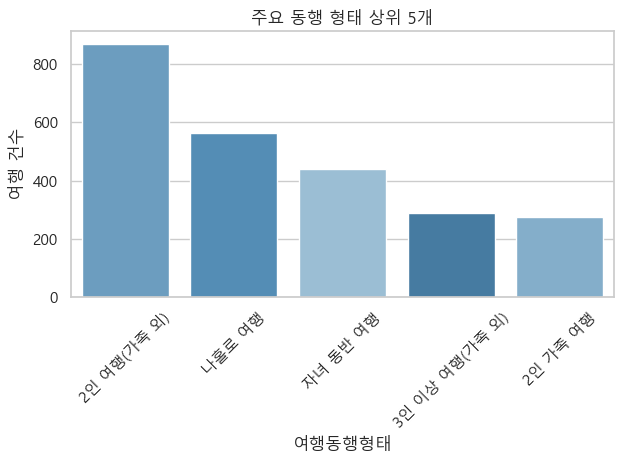

In [139]:

# 주요 범주형 지표 상위 5개 확인
category_candidates = ['여행목적', '여행동행형태']
category_column = next((col for col in category_candidates if col in viz_df.columns), None)

if category_column:
    category_df = viz_df[[category_column]].copy()
    category_df[category_column] = category_df[category_column].fillna('미입력')

    top_categories = category_df[category_column].value_counts().head(5).index
    ax = sns.countplot(
        data=category_df,
        x=category_column,
        order=top_categories,
        hue=category_column,
        palette='Blues_d',
        legend=False,
    )
    title_map = {'여행목적': '주요 여행 목적 상위 5개', '여행동행형태': '주요 동행 형태 상위 5개'}
    ax.set_title(title_map.get(category_column, f'{category_column} 상위 5개'))
    ax.set_xlabel(category_column)
    ax.set_ylabel('여행 건수')
    ax.tick_params(axis='x', rotation=45)
    ax.figure.tight_layout()
else:
    print('여행 목적/동행형태 컬럼을 찾을 수 없어 막대 그래프를 생략합니다.')


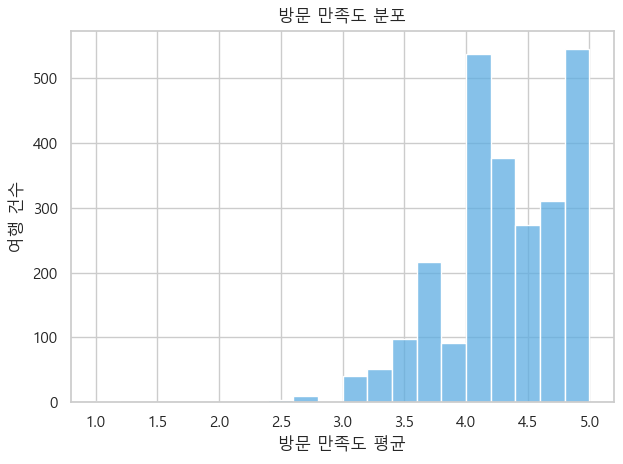

In [140]:
# 방문 만족도 분포 확인
satisfaction_df = viz_df[['방문만족도평균']].dropna()

if not satisfaction_df.empty:
    ax = sns.histplot(data=satisfaction_df, x='방문만족도평균', bins=20, color='#5DADE2')
    ax.set_title('방문 만족도 분포')
    ax.set_xlabel('방문 만족도 평균')
    ax.set_ylabel('여행 건수')
    ax.figure.tight_layout()
else:
    print('방문 만족도 데이터가 없습니다.')


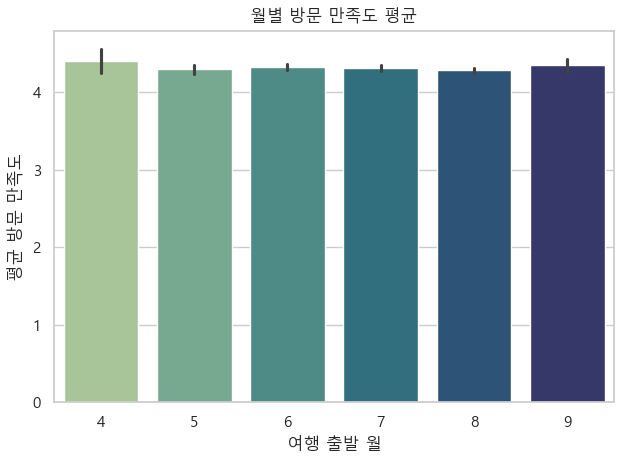

In [141]:

# 월별 방문 만족도 평균 비교
month_df = viz_df[['여행출발월', '방문만족도평균']].dropna()

if not month_df.empty:
    month_order = sorted(month_df['여행출발월'].unique())
    ax = sns.barplot(
        data=month_df,
        x='여행출발월',
        y='방문만족도평균',
        order=month_order,
        hue='여행출발월',
        palette='crest',
        legend=False,
    )
    ax.set_title('월별 방문 만족도 평균')
    ax.set_xlabel('여행 출발 월')
    ax.set_ylabel('평균 방문 만족도')
    ax.figure.tight_layout()
else:
    print('월별 방문 만족도 데이터를 확인할 수 없습니다.')


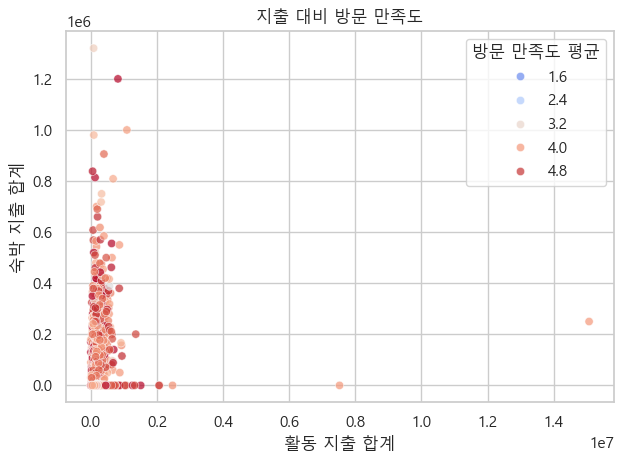

In [142]:
# 활동/숙박 지출과 만족도 관계 보기
scatter_cols = ['활동지출합계', '숙박지출합계', '방문만족도평균']
scatter_df = viz_df[scatter_cols].dropna()

if not scatter_df.empty:
    ax = sns.scatterplot(
        data=scatter_df,
        x='활동지출합계',
        y='숙박지출합계',
        hue='방문만족도평균',
        palette='coolwarm',
        alpha=0.7,
    )
    ax.set_title('지출 대비 방문 만족도')
    ax.set_xlabel('활동 지출 합계')
    ax.set_ylabel('숙박 지출 합계')
    ax.legend(title='방문 만족도 평균', loc='upper right', frameon=True)
    ax.figure.tight_layout()
else:
    print('지출과 만족도를 비교할 데이터가 부족합니다.')


### 6단계: 만족도 심층 탐색
- 월별 평균 그래프의 낮은 편차를 보완하기 위해 travel_insights 기반 지표를 다각도로 검토합니다.
- 동행, 지출, 체류 특성의 교차를 통해 재방문·추천과의 연관성을 살펴봅니다.

In [143]:
metric_focus = [
    'visit_dgstfn_avg',
    'visit_revisit_avg',
    'visit_rcmdtn_avg',
    'visit_rate',
    'visit_trip_days',
    'visit_move_cnt',
    'TRAVEL_DURATION_DAYS',
    'TRAVEL_COMPANIONS_NUM',
    'activity_payment_sum',
    'lodging_payment_sum',
    'activity_type_unique',
]
stat_summary = travel_df[metric_focus].describe().T
stat_view = stat_summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
display(stat_view.round(2))

,count,mean,std,min,25%,50%,75%,max
visit_dgstfn_avg,"2,560",4,1,1,4,4,5,5
visit_revisit_avg,"2,560",4,1,1,4,4,5,5
visit_rcmdtn_avg,"2,560",4,1,2,4,4,5,5
visit_rate,"2,560",0,0,0,0,0,0,1
visit_trip_days,"2,560",2,1,2,2,2,3,6
visit_move_cnt,"2,560",6,4,1,3,5,8,36
TRAVEL_DURATION_DAYS,"2,560",1,1,1,1,1,2,5
TRAVEL_COMPANIONS_NUM,"2,560",1,1,0,1,1,2,20
activity_payment_sum,"2,560","148,345","364,864",0,"54,325","94,688","168,000","15,071,450"
lodging_payment_sum,"2,560","43,377","110,152",0,0,0,0,"1,320,000"


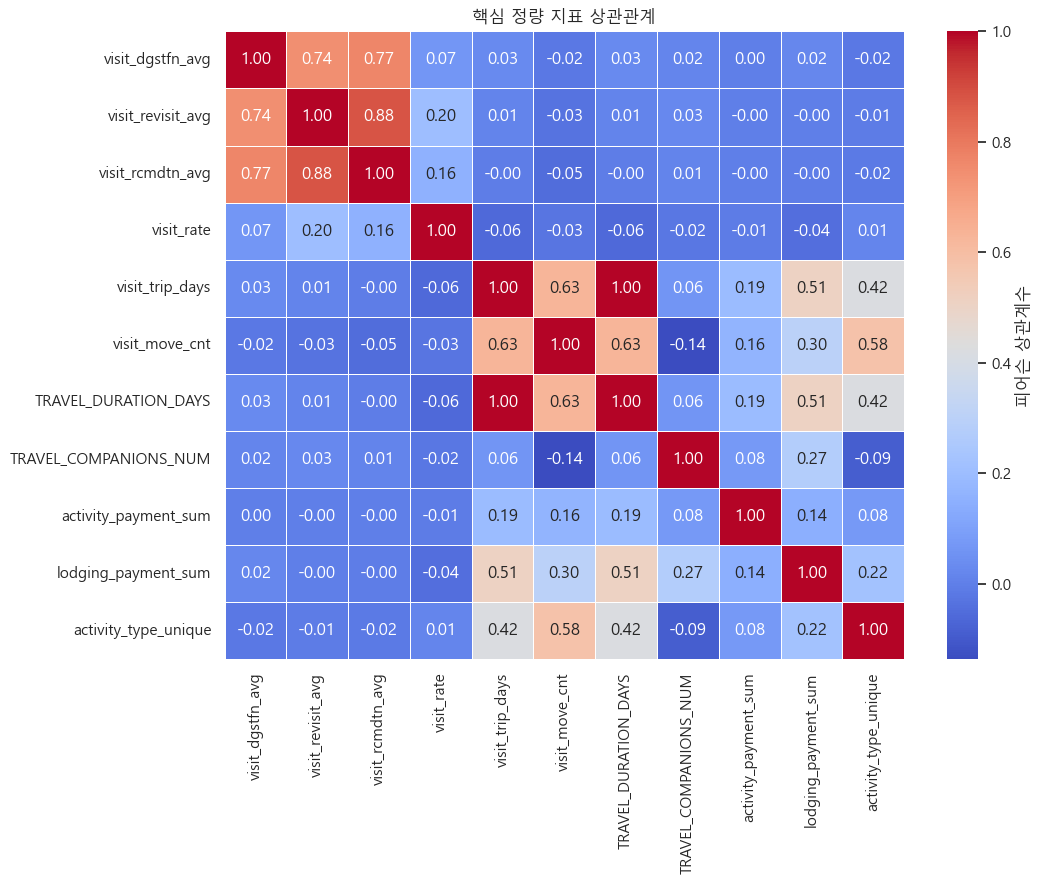

In [144]:
corr_cols = [
    'visit_dgstfn_avg',
    'visit_revisit_avg',
    'visit_rcmdtn_avg',
    'visit_rate',
    'visit_trip_days',
    'visit_move_cnt',
    'TRAVEL_DURATION_DAYS',
    'TRAVEL_COMPANIONS_NUM',
    'activity_payment_sum',
    'lodging_payment_sum',
    'activity_type_unique',
]
corr_matrix = travel_df[corr_cols].corr()
plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.4,
    cbar_kws={'label': '피어슨 상관계수'},
)
plt.title('핵심 정량 지표 상관관계')
plt.tight_layout()

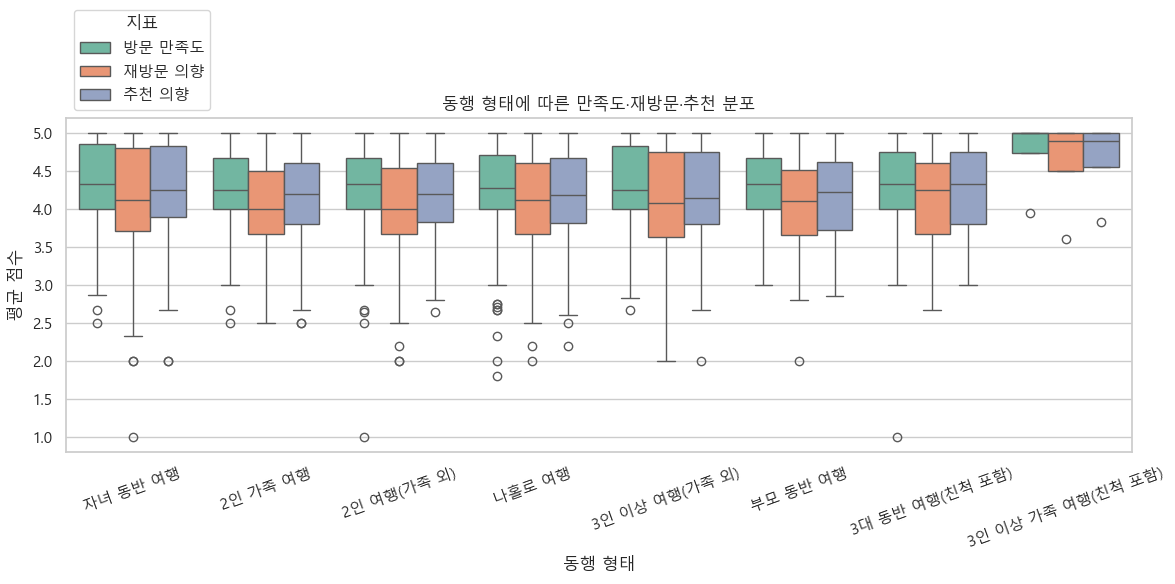

In [145]:
companion_metrics = {
    'visit_dgstfn_avg': '방문 만족도',
    'visit_revisit_avg': '재방문 의향',
    'visit_rcmdtn_avg': '추천 의향',
}
companion_df = travel_df[['TRAVEL_STATUS_ACCOMPANY'] + list(companion_metrics)].dropna()
if not companion_df.empty:
    melted_companion = companion_df.melt(
        id_vars='TRAVEL_STATUS_ACCOMPANY',
        value_vars=list(companion_metrics),
        var_name='metric',
        value_name='score',
    )
    melted_companion['metric_label'] = melted_companion['metric'].map(companion_metrics)
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=melted_companion,
        x='TRAVEL_STATUS_ACCOMPANY',
        y='score',
        hue='metric_label',
        palette='Set2',
    )
    plt.title('동행 형태에 따른 만족도·재방문·추천 분포')
    plt.xlabel('동행 형태')
    plt.ylabel('평균 점수')
    plt.xticks(rotation=20)
    plt.legend(title='지표', loc='lower left', bbox_to_anchor=(0, 1))
    plt.tight_layout()
else:
    print('동행 형태가 비어 있어 박스플롯을 그릴 수 없습니다.')

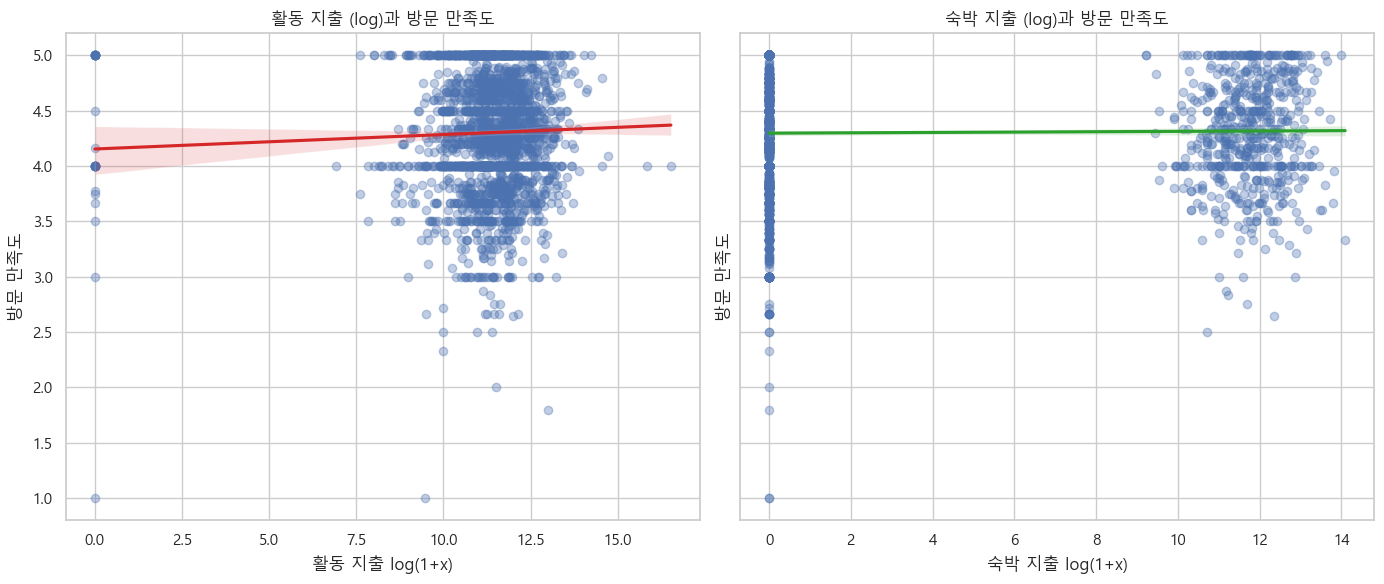

In [146]:
payment_plot_df = travel_df[['activity_payment_sum', 'lodging_payment_sum', 'visit_dgstfn_avg']].dropna()
if not payment_plot_df.empty:
    payment_plot_df = payment_plot_df.assign(
        activity_pay_log=np.log1p(payment_plot_df['activity_payment_sum']),
        lodging_pay_log=np.log1p(payment_plot_df['lodging_payment_sum']),
    )
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.regplot(
        data=payment_plot_df,
        x='activity_pay_log',
        y='visit_dgstfn_avg',
        ax=axes[0],
        scatter_kws={'alpha': 0.35},
        line_kws={'color': '#d62728'},
    )
    axes[0].set_title('활동 지출 (log)과 방문 만족도')
    axes[0].set_xlabel('활동 지출 log(1+x)')
    axes[0].set_ylabel('방문 만족도')

    sns.regplot(
        data=payment_plot_df,
        x='lodging_pay_log',
        y='visit_dgstfn_avg',
        ax=axes[1],
        scatter_kws={'alpha': 0.35},
        line_kws={'color': '#2ca02c'},
    )
    axes[1].set_title('숙박 지출 (log)과 방문 만족도')
    axes[1].set_xlabel('숙박 지출 log(1+x)')
    axes[1].set_ylabel('방문 만족도')

    plt.tight_layout()
else:
    print('지출 데이터가 부족해 산점도를 그릴 수 없습니다.')

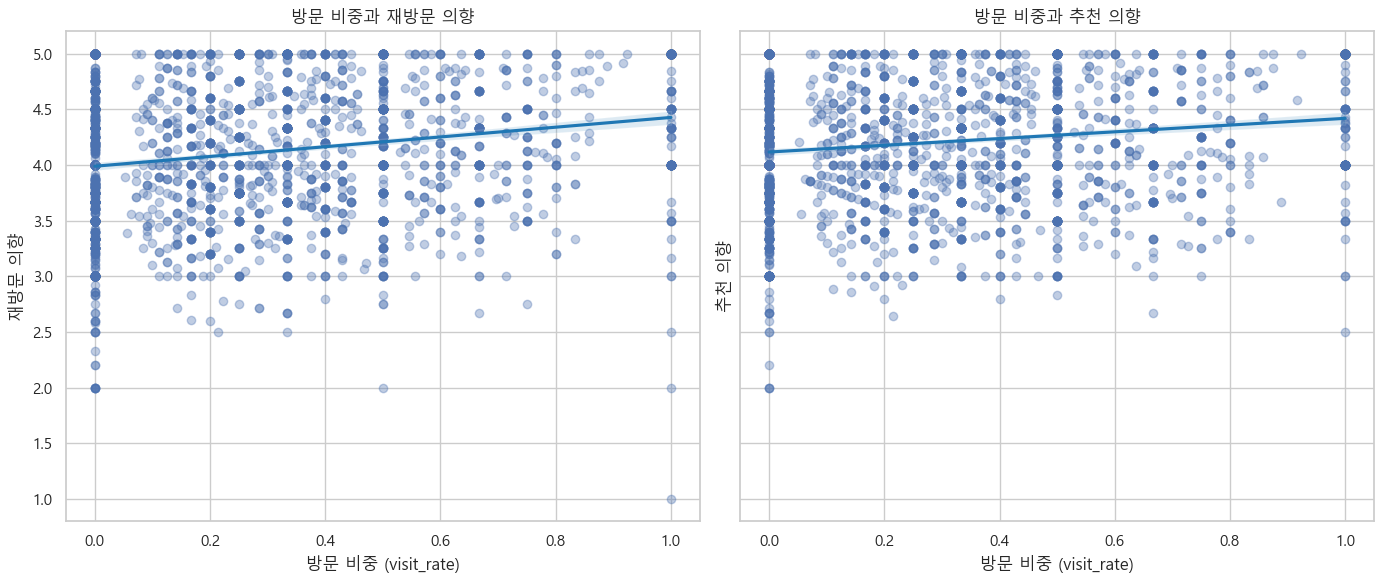

In [147]:
rate_metrics = {
    'visit_revisit_avg': '재방문 의향',
    'visit_rcmdtn_avg': '추천 의향',
}
rate_df = travel_df[['visit_rate'] + list(rate_metrics)].dropna()
if not rate_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    for ax, metric in zip(axes, rate_metrics):
        label = rate_metrics[metric]
        sns.regplot(
            data=rate_df,
            x='visit_rate',
            y=metric,
            ax=ax,
            scatter_kws={'alpha': 0.35},
            line_kws={'color': '#1f77b4'},
        )
        ax.set_title(f'방문 비중과 {label}')
        ax.set_xlabel('방문 비중 (visit_rate)')
        ax.set_ylabel(label)
    plt.tight_layout()
else:
    print('방문 비중 데이터가 부족해 회귀선을 그릴 수 없습니다.')